In [40]:
import os
import random
from math import sqrt
import json
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.metrics import cohen_kappa_score, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [41]:
def _log(str):
    os.system(f'echo \"{str}\"')
    print(str)

In [42]:
NAN = '__NAN__'
INPUT_ROOT = '../input/data-science-bowl-2019'
JOIN_KEY = ['installation_id', 'game_session', 'title']
TARGET = 'accuracy_group'
FEATURES = {
    'event_id', 
    'game_session', 
    'timestamp', 
    'installation_id', 
    'event_count',
    'event_code', 
    'game_time', 
    'title', 
    'type', 
    'world',
    'event_data'
}
EVENT_CODES = ['2000', '2010', '2020', '2025', '2030', '2035', '2040', '2050', '2060', '2070', '2075', '2080', '2081', '2083', '3010', '3020', '3021', '3110', '3120', '3121', '4010', '4020', '4021', '4022', '4025', '4030', '4031', '4035', '4040', '4045', '4050', '4070', '4080', '4090', '4095', '4100', '4110', '4220', '4230', '4235', '5000', '5010']
SEED = 31
FOLDS = 3
ESTIMATORS = 1000

In [43]:
def _init():
    # Characters such as empty strings '' or numpy.inf are considered NA values
    pd.set_option('use_inf_as_na', True)
    pd.set_option('display.max_columns', 999)
    pd.set_option('display.max_rows', 999)
    
    
_init()

In [44]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(SEED)

In [45]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk(INPUT_ROOT):
    for filename in filenames:
        _log(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/data-science-bowl-2019\sample_submission.csv
../input/data-science-bowl-2019\test.csv
../input/data-science-bowl-2019\test.csv.zip
../input/data-science-bowl-2019\train.csv
../input/data-science-bowl-2019\train.csv.zip
../input/data-science-bowl-2019\train_labels.csv
../input/data-science-bowl-2019\train_labels.csv.zip


In [46]:
%%time
train_raw = pd.read_csv(f'{INPUT_ROOT}/train.csv', usecols=FEATURES)
train_labels = pd.read_csv(f'{INPUT_ROOT}/train_labels.csv', usecols=JOIN_KEY + [TARGET])
test_raw = pd.read_csv(f'{INPUT_ROOT}/test.csv', usecols=FEATURES)
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 4 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
accuracy_group     17690 non-null int64
dtypes: int64(1), object(3)
memory usage: 552.9+ KB
Wall time: 1min


# Add labels to train data

In [47]:
def _remove_unlabelled_data(train_raw, train_labels):
    return train_raw[train_raw['installation_id'].isin(train_labels['installation_id'].unique())]


train_raw = _remove_unlabelled_data(train_raw, train_labels)

In [48]:
%%time
def _add_labels(train_raw, train_labels, on):
    train_raw = pd.merge(train_raw, train_labels, on=on, how='left')
    train_raw[TARGET] = np.int16(train_raw[TARGET])
    return train_raw


train_raw = _add_labels(train_raw, train_labels, on=JOIN_KEY)
del train_labels

Wall time: 6.24 s


# Extract event data JSON

In [50]:
def _concat_columns(df1, df2):
    """Concatenate the columns of two pandas dataframes in the order of the operands.
    Both dataframes must have the same number of rows.
    """
    assert len(df1) == len(df2)
    res = pd.concat([df1, df2.reindex(df1.index)], axis=1, join='inner')
    assert len(res) == len(df1)
    return res
    

def _extract_event_data(df, keep_cols, chunk_size=100000):
    res = pd.DataFrame()
    _len = len(df)
    all_cols = []
    for i in tqdm(range(0, _len, chunk_size)):
        if i + chunk_size < _len:
            chunk = df[i:i + chunk_size].copy()
        else:
            chunk = df[i:].copy()
        ed = pd.io.json.json_normalize(chunk['event_data'].apply(json.loads)).add_prefix('ed.')
        if i == 0:
            all_cols = ed.columns.values
        ed = ed[keep_cols]
        chunk = _concat_columns(chunk, ed)
        res = pd.concat([res, chunk], ignore_index=True)
    _log(f'{len(all_cols)} event_data={all_cols}')
    assert len(df) == len(res)
    return res


keep_cols = ['ed.identifier', 'ed.duration', 'ed.coordinates.x', 'ed.coordinates.y',
            'ed.coordinates.stage_width', 'ed.coordinates.stage_height',
            'ed.level', 'ed.round', 'ed.correct', 'ed.misses']
train_raw = _extract_event_data(train_raw, keep_cols)
test_raw = _extract_event_data(test_raw, keep_cols)











  0%|                                                           | 0/78 [00:00<?, ?it/s]









  1%|▋                                                  | 1/78 [00:06<08:26,  6.57s/it]









  3%|█▎                                                 | 2/78 [00:13<08:29,  6.71s/it]









  4%|█▉                                                 | 3/78 [00:19<08:16,  6.62s/it]









  5%|██▌                                                | 4/78 [00:26<08:12,  6.65s/it]









  6%|███▎                                               | 5/78 [00:33<08:05,  6.65s/it]









  8%|███▉                                               | 6/78 [00:40<08:12,  6.84s/it]









  9%|████▌                                              | 7/78 [00:47<08:00,  6.76s/it]









 10%|█████▏                                             | 8/78 [00:54<08:00,  6.86s/it]









 12%|█████▉                                             | 9/78 [01:01<08:05,  7.04s/it]









 13%|██████▍        

 82%|█████████████████████████████████████████         | 64/78 [09:29<02:26, 10.45s/it]









 83%|█████████████████████████████████████████▋        | 65/78 [09:40<02:18, 10.63s/it]









 85%|██████████████████████████████████████████▎       | 66/78 [09:50<02:06, 10.57s/it]









 86%|██████████████████████████████████████████▉       | 67/78 [10:00<01:55, 10.52s/it]









 87%|███████████████████████████████████████████▌      | 68/78 [10:11<01:46, 10.63s/it]









 88%|████████████████████████████████████████████▏     | 69/78 [10:22<01:36, 10.76s/it]









 90%|████████████████████████████████████████████▊     | 70/78 [10:33<01:25, 10.72s/it]









 91%|█████████████████████████████████████████████▌    | 71/78 [10:45<01:16, 11.00s/it]









 92%|██████████████████████████████████████████████▏   | 72/78 [10:56<01:06, 11.05s/it]









 94%|██████████████████████████████████████████████▊   | 73/78 [11:07<00:54, 10.96s/it]









 95%|█████████████████████████

136 event_data=['ed.event_code' 'ed.event_count' 'ed.version' 'ed.game_time'
 'ed.description' 'ed.identifier' 'ed.media_type' 'ed.total_duration'
 'ed.coordinates.x' 'ed.coordinates.y' 'ed.coordinates.stage_width'
 'ed.coordinates.stage_height' 'ed.duration' 'ed.size' 'ed.sand'
 'ed.filled' 'ed.castles_placed' 'ed.molds' 'ed.level' 'ed.round'
 'ed.movie_id' 'ed.time_played' 'ed.options' 'ed.animals'
 'ed.round_target.size' 'ed.round_target.type' 'ed.round_target.animal'
 'ed.item_type' 'ed.position' 'ed.animal' 'ed.correct' 'ed.misses'
 'ed.houses' 'ed.dinosaurs' 'ed.dinosaur' 'ed.dinosaurs_placed'
 'ed.house.size' 'ed.house.position' 'ed.rocket' 'ed.height' 'ed.launched'
 'ed.flowers' 'ed.flower' 'ed.growth' 'ed.stumps' 'ed.source'
 'ed.destination' 'ed.session_duration' 'ed.exit_type' 'ed.distance'
 'ed.target_distances' 'ed.round_prompt' 'ed.target_size' 'ed.resources'
 'ed.object_type' 'ed.group' 'ed.bug' 'ed.buglength' 'ed.stage_number'
 'ed.hat' 'ed.caterpillar' 'ed.hats' 'ed.ca











  8%|████▎                                              | 1/12 [00:06<01:15,  6.85s/it]









 17%|████████▌                                          | 2/12 [00:14<01:09,  7.00s/it]









 25%|████████████▊                                      | 3/12 [00:21<01:04,  7.15s/it]









 33%|█████████████████                                  | 4/12 [00:28<00:56,  7.07s/it]









 42%|█████████████████████▎                             | 5/12 [00:36<00:50,  7.22s/it]









 50%|█████████████████████████▌                         | 6/12 [00:44<00:44,  7.41s/it]









 58%|█████████████████████████████▊                     | 7/12 [00:51<00:37,  7.50s/it]









 67%|██████████████████████████████████                 | 8/12 [00:59<00:29,  7.44s/it]









 75%|██████████████████████████████████████▎            | 9/12 [01:06<00:22,  7.54s/it]









 83%|█████████████████████████████████████████▋        | 10/12 [01:14<00:15,  7.54s/it]









 92%|███████████████

134 event_data=['ed.event_code' 'ed.event_count' 'ed.version' 'ed.round' 'ed.game_time'
 'ed.coordinates.x' 'ed.coordinates.y' 'ed.coordinates.stage_width'
 'ed.coordinates.stage_height' 'ed.description' 'ed.identifier'
 'ed.media_type' 'ed.total_duration' 'ed.duration' 'ed.dinosaur' 'ed.diet'
 'ed.target_weight' 'ed.resources' 'ed.weight' 'ed.source' 'ed.correct'
 'ed.scale_weight' 'ed.scale_contents' 'ed.houses' 'ed.dinosaurs'
 'ed.size' 'ed.dinosaurs_placed' 'ed.house.size' 'ed.house.position'
 'ed.misses' 'ed.rocket' 'ed.height' 'ed.launched' 'ed.crystals'
 'ed.crystal_id' 'ed.side' 'ed.left' 'ed.right' 'ed.session_duration'
 'ed.layout.row1' 'ed.layout.row2' 'ed.gate.row' 'ed.gate.column'
 'ed.gate.side' 'ed.nest' 'ed.bug' 'ed.sand' 'ed.filled'
 'ed.castles_placed' 'ed.target_water_level' 'ed.water_level' 'ed.level'
 'ed.movie_id' 'ed.time_played' 'ed.options' 'ed.animals'
 'ed.round_target.size' 'ed.round_target.type' 'ed.round_target.animal'
 'ed.item_type' 'ed.position' 'ed.ani

In [51]:
test_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156414 entries, 0 to 1156413
Data columns (total 21 columns):
event_id                       1156414 non-null object
game_session                   1156414 non-null object
timestamp                      1156414 non-null object
event_data                     1156414 non-null object
installation_id                1156414 non-null object
event_count                    1156414 non-null int64
event_code                     1156414 non-null int64
game_time                      1156414 non-null int64
title                          1156414 non-null object
type                           1156414 non-null object
world                          1156414 non-null object
ed.identifier                  33835 non-null object
ed.duration                    32850 non-null float64
ed.coordinates.x               51261 non-null float64
ed.coordinates.y               51261 non-null float64
ed.coordinates.stage_width     51261 non-null float64
ed.coordinates.s

In [52]:
train_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7734558 entries, 0 to 7734557
Data columns (total 22 columns):
event_id                       object
game_session                   object
timestamp                      object
event_data                     object
installation_id                object
event_count                    int64
event_code                     int64
game_time                      int64
title                          object
type                           object
world                          object
accuracy_group                 int16
ed.identifier                  object
ed.duration                    float64
ed.coordinates.x               float64
ed.coordinates.y               float64
ed.coordinates.stage_width     float64
ed.coordinates.stage_height    float64
ed.level                       float64
ed.round                       float64
ed.correct                     object
ed.misses                      float64
dtypes: float64(8), int16(1), int64(3), object(

In [29]:
# All event ids in test set also exist in train set
test_set = set(test_raw['event_id'])
train_set = set(train_raw['event_id'])
vs = test_set - train_set
_log(f'{len(vs)} event_ids exist in test set but not train set.')

0 event_ids exist in test set but not train set.


In [30]:
EVENT_IDS = sorted(test_raw['event_id'].unique())
_log(f'{len(vs)} EVENT_IDS={vs}')

0 EVENT_IDS=set()


In [31]:
vs = sorted(train_raw['type'].unique())
_log(f'{len(vs)} train_raw type={vs}')

4 train_raw type=['Activity', 'Assessment', 'Clip', 'Game']


In [32]:
vs = sorted(train_raw['world'].unique())
_log(f'{len(vs)} train_raw type={vs}')

4 train_raw type=['CRYSTALCAVES', 'MAGMAPEAK', 'NONE', 'TREETOPCITY']


In [33]:
vs = sorted(train_raw['event_code'].unique())
_log(f'{len(vs)} train_raw type={vs}')

42 train_raw type=[2000, 2010, 2020, 2025, 2030, 2035, 2040, 2050, 2060, 2070, 2075, 2080, 2081, 2083, 3010, 3020, 3021, 3110, 3120, 3121, 4010, 4020, 4021, 4022, 4025, 4030, 4031, 4035, 4040, 4045, 4050, 4070, 4080, 4090, 4095, 4100, 4110, 4220, 4230, 4235, 5000, 5010]


In [34]:
vs = sorted(train_raw['title'].unique())
_log(f'{len(vs)} train_raw titles={vs}')

44 train_raw titles=['12 Monkeys', 'Air Show', 'All Star Sorting', 'Balancing Act', 'Bird Measurer (Assessment)', 'Bottle Filler (Activity)', 'Bubble Bath', 'Bug Measurer (Activity)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Chicken Balancer (Activity)', 'Chow Time', 'Costume Box', 'Crystal Caves - Level 1', 'Crystal Caves - Level 2', 'Crystal Caves - Level 3', 'Crystals Rule', 'Dino Dive', 'Dino Drink', 'Egg Dropper (Activity)', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Happy Camel', 'Heavy, Heavier, Heaviest', 'Honey Cake', 'Leaf Leader', 'Lifting Heavy Things', 'Magma Peak - Level 1', 'Magma Peak - Level 2', 'Mushroom Sorter (Assessment)', 'Ordering Spheres', 'Pan Balance', "Pirate's Tale", 'Rulers', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Slop Problem', 'Treasure Map', 'Tree Top City - Level 1', 'Tree Top City - Level 2', 'Tree Top City - Level 3', 'Watering Hole (Activity)', 'Welcome to Lost Lagoon!']


In [35]:
vs = sorted(test_raw['title'].unique())
_log(f'{len(vs)} test titles={vs}')

44 test titles=['12 Monkeys', 'Air Show', 'All Star Sorting', 'Balancing Act', 'Bird Measurer (Assessment)', 'Bottle Filler (Activity)', 'Bubble Bath', 'Bug Measurer (Activity)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Chicken Balancer (Activity)', 'Chow Time', 'Costume Box', 'Crystal Caves - Level 1', 'Crystal Caves - Level 2', 'Crystal Caves - Level 3', 'Crystals Rule', 'Dino Dive', 'Dino Drink', 'Egg Dropper (Activity)', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Happy Camel', 'Heavy, Heavier, Heaviest', 'Honey Cake', 'Leaf Leader', 'Lifting Heavy Things', 'Magma Peak - Level 1', 'Magma Peak - Level 2', 'Mushroom Sorter (Assessment)', 'Ordering Spheres', 'Pan Balance', "Pirate's Tale", 'Rulers', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Slop Problem', 'Treasure Map', 'Tree Top City - Level 1', 'Tree Top City - Level 2', 'Tree Top City - Level 3', 'Watering Hole (Activity)', 'Welcome to Lost Lagoon!']


In [37]:
def _transform_timestamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df


train_raw = _transform_timestamp(train_raw)
test_raw = _transform_timestamp(test_raw)

In [38]:
%%time
def _set_string_type(df, cols):
    df[cols] = df[cols].fillna(NAN).astype(str)
    return df


cols = ['event_code', 'timestamp']
train_raw = _set_string_type(train_raw, cols=cols)
test_raw = _set_string_type(test_raw, cols=cols)

Wall time: 1min 18s


In [39]:
%%time
def _sort_it(df):
    return df.sort_values(by=['installation_id', 'timestamp'])


train_raw = _sort_it(train_raw)
test_raw = _sort_it(test_raw)

Wall time: 25 s


# Multiple accuracy groups per installation id
In the train set, there are multiple accuracy groups per installation id. The task is to predict the accuracy group of the **last** assessment for a given installation id.

In [40]:
vs = train_raw[train_raw[TARGET].notna()].groupby('installation_id')[TARGET].nunique()
vs

installation_id
0006a69f    3
0006c192    3
00129856    1
001d0ed0    3
00225f67    1
           ..
ff9305d7    2
ff9715db    4
ffc90c32    2
ffd2871d    1
ffeb0b1b    2
Name: accuracy_group, Length: 3614, dtype: int64

In [41]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7734558 entries, 0 to 7734557
Data columns (total 12 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         object
game_time          int64
title              object
type               object
world              object
accuracy_group     float64
dtypes: float64(1), int64(2), object(9)
memory usage: 767.1+ MB


In [42]:
def _log_smoothing(df, cols):
    for col in cols:
        df[col] = np.log(df[col] + 1)
    return df


#cols = ['event_count', 'game_time']
#train = _log_smoothing(train, cols)
#test = _log_smoothing(test, cols)

In [43]:
train_raw.head(40)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,accuracy_group
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,NaN
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,NaN
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
5,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:18.474000+00:00,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
6,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:19.365000+00:00,"{""coordinates"":{""x"":817,""y"":617,""stage_width"":...",0006a69f,5,4070,4820,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
7,1bb5fbdb,2b9d5af79bcdb79f,2019-08-06 04:58:21.490000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,6,3110,6954,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
8,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:22.732000+00:00,"{""coordinates"":{""x"":809,""y"":180,""stage_width"":...",0006a69f,7,4070,8187,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
9,5e812b27,2b9d5af79bcdb79f,2019-08-06 04:58:23.295000+00:00,"{""size"":0,""coordinates"":{""x"":782,""y"":207,""stag...",0006a69f,8,4030,8745,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN


In [44]:
test_raw.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10 16:50:24.910000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10 16:50:55.503000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10 16:51:51.805000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10 16:53:12.825000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10 16:54:12.115000+00:00,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


# Train-test split not by time
Both train and test sets span the same time period.

In [45]:
_log(f'train[timestamp] is from {train_raw.timestamp.min()} to {train_raw.timestamp.max()}')
_log(f'test[timestamp] is from {test_raw.timestamp.min()} to {test_raw.timestamp.max()}')

train[timestamp] is from 2019-07-23 14:38:25.256000+00:00 to 2019-10-14 21:57:26.930000+00:00
test[timestamp] is from 2019-07-24 00:04:25.361000+00:00 to 2019-10-14 21:00:34.858000+00:00


# Feature Engineering

In [71]:
def _cutoff(df, TARGET):
    return df[df[TARGET].notna()]['timestamp'].max()


def _trim_events_after_last_assessment(df, cutoff):
    res = df[df['timestamp'] <= cutoff]
    #_log(f'cutoff: before={df.shape}, after={res.shape}')
    return res
    
    
def _target_variable(df, cutoff, TARGET):
    vs = df[df['timestamp'] == cutoff][TARGET].values
    assert len(set(vs)) == 1
    return int(float(vs[0]))
    
    
def _game_session_stats(df, col):
    vs = df.groupby(['game_session'])[col].transform('max')
    return (vs.median(), vs.max())


def _event_code_counts(df, code):
    total = np.int32([sum(df['event_code'] == code)])
    activity = np.int32([sum((df['event_code'] == code) & (df['type'] == 'Activity'))])
    assessment = np.int32([sum((df['event_code'] == code) & (df['type'] == 'Assessment'))])
    clip = np.int32([sum((df['event_code'] == code) & (df['type'] == 'Clip'))])
    game = np.int32([sum((df['event_code'] == code) & (df['type'] == 'Game'))])
    return (total, activity, assessment, clip, game)


def _features_map(df, EVENT_CODES, EVENT_IDS, suffix=''):
    res = {}
    res[f'type_activity{suffix}'] = np.int32([sum(df['type'] == 'Activity')])
    res[f'type_assessment{suffix}'] = np.int32([sum(df['type'] == 'Assessment')])
    res[f'type_clip{suffix}'] = np.int32([sum(df['type'] == 'Clip')])
    res[f'type_game{suffix}'] = np.int32([sum(df['type'] == 'Game')])
    assert len(df) == res[f'type_activity{suffix}'][0] + res[f'type_assessment{suffix}'][0] + res[f'type_clip{suffix}'][0] + res[f'type_game{suffix}'][0]
    res[f'world_crystalcaves{suffix}'] = np.int32([sum(df['world'] == 'CRYSTALCAVES')])
    res[f'world_magmapeak{suffix}'] = np.int32([sum(df['world'] == 'MAGMAPEAK')])
    res[f'world_treetopcity{suffix}'] = np.int32([sum(df['world'] == 'TREETOPCITY')])
    res[f'world_none{suffix}'] = np.int32([sum(df['world'] == 'NONE')])
    res[f'title_12_monkeys{suffix}'] = np.int32([sum(df['title'] == '12 Monkeys')])
    res[f'title_air_show{suffix}'] = np.int32([sum(df['title'] == 'Air Show')])
    res[f'title_all_star_sorting{suffix}'] = np.int32([sum(df['title'] == 'All Star Sorting')])
    res[f'title_balancing_act{suffix}'] = np.int32([sum(df['title'] == 'Balancing Act')])
    res[f'title_bird_measurer{suffix}'] = np.int32([sum(df['title'] == 'Bird Measurer (Assessment)')])
    res[f'title_bottle_filler{suffix}'] = np.int32([sum(df['title'] == 'Bottle Filler (Activity)')])
    res[f'title_bubble_bath{suffix}'] = np.int32([sum(df['title'] == 'Bubble Bath')])
    res[f'title_bug_measurer{suffix}'] = np.int32([sum(df['title'] == 'Bug Measurer (Activity)')])
    res[f'title_cart_balancer{suffix}'] = np.int32([sum(df['title'] == 'Cart Balancer (Assessment)')])
    res[f'title_cauldron_filler{suffix}'] = np.int32([sum(df['title'] == 'Cauldron Filler (Assessment)')])
    res[f'title_chest_sorter{suffix}'] = np.int32([sum(df['title'] == 'Chest Sorter (Assessment)')])
    res[f'title_chicken_balancer{suffix}'] = np.int32([sum(df['title'] == 'Chicken Balancer (Activity)')])
    res[f'title_chow_time{suffix}'] = np.int32([sum(df['title'] == 'Chow Time')])
    res[f'title_costume_box{suffix}'] = np.int32([sum(df['title'] == 'Costume Box')])
    res[f'title_crystal_caves_1{suffix}'] = np.int32([sum(df['title'] == 'Crystal Caves - Level 1')])
    res[f'title_crystal_caves_2{suffix}'] = np.int32([sum(df['title'] == 'Crystal Caves - Level 2')])
    res[f'title_crystal_caves_3{suffix}'] = np.int32([sum(df['title'] == 'Crystal Caves - Level 3')])
    res[f'title_crystals_rule{suffix}'] = np.int32([sum(df['title'] == 'Crystals Rule')])
    res[f'title_dino_dive{suffix}'] = np.int32([sum(df['title'] == 'Dino Dive')])
    res[f'title_dino_drink{suffix}'] = np.int32([sum(df['title'] == 'Dino Drink')])
    res[f'title_egg_dropper{suffix}'] = np.int32([sum(df['title'] == 'Egg Dropper (Activity)')])
    res[f'title_fireworks{suffix}'] = np.int32([sum(df['title'] == 'Fireworks (Activity)')])
    res[f'title_flower_waterer{suffix}'] = np.int32([sum(df['title'] == 'Flower Waterer (Activity)')])
    res[f'title_happy_camel{suffix}'] = np.int32([sum(df['title'] == 'Happy Camel')])
    res[f'title_heavy{suffix}'] = np.int32([sum(df['title'] == 'Heavy, Heavier, Heaviest')])
    res[f'title_honey_cake{suffix}'] = np.int32([sum(df['title'] == 'Honey Cake')])
    res[f'title_leaf_leader{suffix}'] = np.int32([sum(df['title'] == 'Leaf Leader')])
    res[f'title_lifting{suffix}'] = np.int32([sum(df['title'] == 'Lifting Heavy Things')])
    res[f'title_magma_peak_1{suffix}'] = np.int32([sum(df['title'] == 'Magma Peak - Level 1')])
    res[f'title_magma_peak_2{suffix}'] = np.int32([sum(df['title'] == 'Magma Peak - Level 2')])
    res[f'title_mushroom_sorter{suffix}'] = np.int32([sum(df['title'] == 'Mushroom Sorter (Assessment)')])
    res[f'title_ordering_spheres{suffix}'] = np.int32([sum(df['title'] == 'Ordering Spheres')])
    res[f'title_pan_balance{suffix}'] = np.int32([sum(df['title'] == 'Pan Balance')])
    res[f'title_pirate_tale{suffix}'] = np.int32([sum(df['title'] == "Pirate's Tale")])
    res[f'title_rulers{suffix}'] = np.int32([sum(df['title'] == 'Rulers')])
    res[f'title_sandcastle{suffix}'] = np.int32([sum(df['title'] == 'Sandcastle Builder (Activity)')])
    res[f'title_scrub{suffix}'] = np.int32([sum(df['title'] == 'Scrub-A-Dub')])
    res[f'title_slop{suffix}'] = np.int32([sum(df['title'] == 'Slop Problem')])
    res[f'title_treasure_map{suffix}'] = np.int32([sum(df['title'] == 'Treasure Map')])
    res[f'title_treetop_city_1{suffix}'] = np.int32([sum(df['title'] == 'Tree Top City - Level 1')])
    res[f'title_treetop_city_2{suffix}'] = np.int32([sum(df['title'] == 'Tree Top City - Level 2')])
    res[f'title_treetop_city_3{suffix}'] = np.int32([sum(df['title'] == 'Tree Top City - Level 3')])
    res[f'title_watering_hole{suffix}'] = np.int32([sum(df['title'] == 'Watering Hole (Activity)')])
    res[f'title_welcome{suffix}'] = np.int32([sum(df['title'] == 'Welcome to Lost Lagoon!')])
    
    for code in EVENT_CODES:
        (total, activity, assessment, clip, game) = _event_code_counts(df, code)
        res[f'event_{code}{suffix}'] = total
        res[f'event_{code}_activity{suffix}'] = activity
        res[f'event_{code}_assessment{suffix}'] = assessment
        res[f'event_{code}_clip{suffix}'] = clip
        res[f'event_{code}_game{suffix}'] = game
    
    for eid in EVENT_IDS:
        res[f'eid_{eid}{suffix}'] = np.int32([sum(df['event_id'] == eid)])
    
    res[f'game_time{suffix}'] = np.int32(df['game_time'].max())
    res[f'event_count{suffix}'] = np.int32(df['event_count'].max())
    return res


def _features(df, installation_id, EVENT_CODES, EVENT_IDS):
    res = {}
    iid = df[df['installation_id'] == installation_id]
    if TARGET in df.columns:
        cutoff = _cutoff(iid, TARGET)
        iid = _trim_events_after_last_assessment(iid, cutoff)
        res[TARGET] = _target_variable(iid, cutoff, TARGET)
    res['installation_id'] = [installation_id]
    cols = ['game_time', 'event_count']
    for col in cols:
        (_median, _max) = np.int32(_game_session_stats(iid, col))
        res[f'{col}_p50'] = _median
        res[f'{col}_max'] = _max
    res.update(_features_map(iid, EVENT_CODES, EVENT_IDS))
    return pd.DataFrame.from_dict(res)


def _preprocess(raw, EVENT_CODES, EVENT_IDS):
    res = pd.DataFrame()
    iids = raw['installation_id'].unique()
    for iid in tqdm(iids):
        res = pd.concat([res, _features(raw, iid, EVENT_CODES, EVENT_IDS)])
    return res


train = _preprocess(train_raw, EVENT_CODES, EVENT_IDS)
train.info(max_cols=999)

100%|██████████████████████████████████████████████| 3614/3614 [54:43<00:00,  1.10it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3614 entries, 0 to 0
Data columns (total 635 columns):
accuracy_group            3614 non-null int64
installation_id           3614 non-null object
game_time_p50             3614 non-null int32
game_time_max             3614 non-null int32
event_count_p50           3614 non-null int32
event_count_max           3614 non-null int32
type_activity             3614 non-null int32
type_assessment           3614 non-null int32
type_clip                 3614 non-null int32
type_game                 3614 non-null int32
world_crystalcaves        3614 non-null int32
world_magmapeak           3614 non-null int32
world_treetopcity         3614 non-null int32
world_none                3614 non-null int32
title_12_monkeys          3614 non-null int32
title_air_show            3614 non-null int32
title_all_star_sorting    3614 non-null int32
title_balancing_act       3614 non-null int32
title_bird_measurer       3614 non-null int32
title_bottle_filler 

In [72]:
train.head(10)

,accuracy_group,installation_id,game_time_p50,game_time_max,event_count_p50,event_count_max,type_activity,type_assessment,type_clip,type_game,world_crystalcaves,world_magmapeak,world_treetopcity,world_none,title_12_monkeys,title_air_show,title_all_star_sorting,title_balancing_act,title_bird_measurer,title_bottle_filler,title_bubble_bath,title_bug_measurer,title_cart_balancer,title_cauldron_filler,title_chest_sorter,title_chicken_balancer,title_chow_time,title_costume_box,title_crystal_caves_1,title_crystal_caves_2,title_crystal_caves_3,title_crystals_rule,title_dino_dive,title_dino_drink,title_egg_dropper,title_fireworks,title_flower_waterer,title_happy_camel,title_heavy,title_honey_cake,title_leaf_leader,title_lifting,title_magma_peak_1,title_magma_peak_2,title_mushroom_sorter,title_ordering_spheres,title_pan_balance,title_pirate_tale,title_rulers,title_sandcastle,title_scrub,title_slop,title_treasure_map,title_treetop_city_1,title_treetop_city_2,title_treetop_city_3,title_watering_hole,title_welcome,event_2000,event_2000_activity,event_2000_assessment,event_2000_clip,event_2000_game,event_2010,event_2010_activity,event_2010_assessment,event_2010_clip,event_2010_game,event_2020,event_2020_activity,event_2020_assessment,event_2020_clip,event_2020_game,event_2025,event_2025_activity,event_2025_assessment,event_2025_clip,event_2025_game,event_2030,event_2030_activity,event_2030_assessment,event_2030_clip,event_2030_game,event_2035,event_2035_activity,event_2035_assessment,event_2035_clip,event_2035_game,event_2040,event_2040_activity,event_2040_assessment,event_2040_clip,event_2040_game,event_2050,event_2050_activity,event_2050_assessment,event_2050_clip,event_2050_game,event_2060,event_2060_activity,event_2060_assessment,event_2060_clip,event_2060_game,event_2070,event_2070_activity,event_2070_assessment,event_2070_clip,event_2070_game,event_2075,event_2075_activity,event_2075_assessment,event_2075_clip,event_2075_game,event_2080,event_2080_activity,event_2080_assessment,event_2080_clip,event_2080_game,event_2081,event_2081_activity,event_2081_assessment,event_2081_clip,event_2081_game,event_2083,event_2083_activity,event_2083_assessment,event_2083_clip,event_2083_game,event_3010,event_3010_activity,event_3010_assessment,event_3010_clip,event_3010_game,event_3020,event_3020_activity,event_3020_assessment,event_3020_clip,event_3020_game,event_3021,event_3021_activity,event_3021_assessment,event_3021_clip,event_3021_game,event_3110,event_3110_activity,event_3110_assessment,event_3110_clip,event_3110_game,event_3120,event_3120_activity,event_3120_assessment,event_3120_clip,event_3120_game,event_3121,event_3121_activity,event_3121_assessment,event_3121_clip,event_3121_game,event_4010,event_4010_activity,event_4010_assessment,event_4010_clip,event_4010_game,event_4020,event_4020_activity,event_4020_assessment,event_4020_clip,event_4020_game,event_4021,event_4021_activity,event_4021_assessment,event_4021_clip,event_4021_game,event_4022,event_4022_activity,event_4022_assessment,event_4022_clip,event_4022_game,event_4025,event_4025_activity,event_4025_assessment,event_4025_clip,event_4025_game,event_4030,event_4030_activity,event_4030_assessment,event_4030_clip,event_4030_game,event_4031,event_4031_activity,event_4031_assessment,event_4031_clip,event_4031_game,event_4035,event_4035_activity,event_4035_assessment,event_4035_clip,event_4035_game,event_4040,event_4040_activity,event_4040_assessment,event_4040_clip,event_4040_game,event_4045,event_4045_activity,event_4045_assessment,event_4045_clip,event_4045_game,event_4050,event_4050_activity,event_4050_assessment,event_4050_clip,event_4050_game,event_4070,event_4070_activity,event_4070_assessment,event_4070_clip,event_4070_game,event_4080,event_4080_activity,event_4080_assessment,event_4080_clip,event_4080_game,event_4090,event_4090_activity,event_4090_assessment,event_4090_clip,event_4090_game,event_4095,event_4095_activity,event_4095_assessment,event_4095_clip,event_4095_game,event_41

In [73]:
test = _preprocess(test_raw, EVENT_CODES, EVENT_IDS)
test.info(max_cols=999)

100%|██████████████████████████████████████████████| 1000/1000 [07:17<00:00,  2.28it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 0
Data columns (total 634 columns):
installation_id           1000 non-null object
game_time_p50             1000 non-null int32
game_time_max             1000 non-null int32
event_count_p50           1000 non-null int32
event_count_max           1000 non-null int32
type_activity             1000 non-null int32
type_assessment           1000 non-null int32
type_clip                 1000 non-null int32
type_game                 1000 non-null int32
world_crystalcaves        1000 non-null int32
world_magmapeak           1000 non-null int32
world_treetopcity         1000 non-null int32
world_none                1000 non-null int32
title_12_monkeys          1000 non-null int32
title_air_show            1000 non-null int32
title_all_star_sorting    1000 non-null int32
title_balancing_act       1000 non-null int32
title_bird_measurer       1000 non-null int32
title_bottle_filler       1000 non-null int32
title_bubble_bath   

In [74]:
test.head(20)

,installation_id,game_time_p50,game_time_max,event_count_p50,event_count_max,type_activity,type_assessment,type_clip,type_game,world_crystalcaves,world_magmapeak,world_treetopcity,world_none,title_12_monkeys,title_air_show,title_all_star_sorting,title_balancing_act,title_bird_measurer,title_bottle_filler,title_bubble_bath,title_bug_measurer,title_cart_balancer,title_cauldron_filler,title_chest_sorter,title_chicken_balancer,title_chow_time,title_costume_box,title_crystal_caves_1,title_crystal_caves_2,title_crystal_caves_3,title_crystals_rule,title_dino_dive,title_dino_drink,title_egg_dropper,title_fireworks,title_flower_waterer,title_happy_camel,title_heavy,title_honey_cake,title_leaf_leader,title_lifting,title_magma_peak_1,title_magma_peak_2,title_mushroom_sorter,title_ordering_spheres,title_pan_balance,title_pirate_tale,title_rulers,title_sandcastle,title_scrub,title_slop,title_treasure_map,title_treetop_city_1,title_treetop_city_2,title_treetop_city_3,title_watering_hole,title_welcome,event_2000,event_2000_activity,event_2000_assessment,event_2000_clip,event_2000_game,event_2010,event_2010_activity,event_2010_assessment,event_2010_clip,event_2010_game,event_2020,event_2020_activity,event_2020_assessment,event_2020_clip,event_2020_game,event_2025,event_2025_activity,event_2025_assessment,event_2025_clip,event_2025_game,event_2030,event_2030_activity,event_2030_assessment,event_2030_clip,event_2030_game,event_2035,event_2035_activity,event_2035_assessment,event_2035_clip,event_2035_game,event_2040,event_2040_activity,event_2040_assessment,event_2040_clip,event_2040_game,event_2050,event_2050_activity,event_2050_assessment,event_2050_clip,event_2050_game,event_2060,event_2060_activity,event_2060_assessment,event_2060_clip,event_2060_game,event_2070,event_2070_activity,event_2070_assessment,event_2070_clip,event_2070_game,event_2075,event_2075_activity,event_2075_assessment,event_2075_clip,event_2075_game,event_2080,event_2080_activity,event_2080_assessment,event_2080_clip,event_2080_game,event_2081,event_2081_activity,event_2081_assessment,event_2081_clip,event_2081_game,event_2083,event_2083_activity,event_2083_assessment,event_2083_clip,event_2083_game,event_3010,event_3010_activity,event_3010_assessment,event_3010_clip,event_3010_game,event_3020,event_3020_activity,event_3020_assessment,event_3020_clip,event_3020_game,event_3021,event_3021_activity,event_3021_assessment,event_3021_clip,event_3021_game,event_3110,event_3110_activity,event_3110_assessment,event_3110_clip,event_3110_game,event_3120,event_3120_activity,event_3120_assessment,event_3120_clip,event_3120_game,event_3121,event_3121_activity,event_3121_assessment,event_3121_clip,event_3121_game,event_4010,event_4010_activity,event_4010_assessment,event_4010_clip,event_4010_game,event_4020,event_4020_activity,event_4020_assessment,event_4020_clip,event_4020_game,event_4021,event_4021_activity,event_4021_assessment,event_4021_clip,event_4021_game,event_4022,event_4022_activity,event_4022_assessment,event_4022_clip,event_4022_game,event_4025,event_4025_activity,event_4025_assessment,event_4025_clip,event_4025_game,event_4030,event_4030_activity,event_4030_assessment,event_4030_clip,event_4030_game,event_4031,event_4031_activity,event_4031_assessment,event_4031_clip,event_4031_game,event_4035,event_4035_activity,event_4035_assessment,event_4035_clip,event_4035_game,event_4040,event_4040_activity,event_4040_assessment,event_4040_clip,event_4040_game,event_4045,event_4045_activity,event_4045_assessment,event_4045_clip,event_4045_game,event_4050,event_4050_activity,event_4050_assessment,event_4050_clip,event_4050_game,event_4070,event_4070_activity,event_4070_assessment,event_4070_clip,event_4070_game,event_4080,event_4080_activity,event_4080_assessment,event_4080_clip,event_4080_game,event_4090,event_4090_activity,event_4090_assessment,event_4090_clip,event_4090_game,event_4095,event_4095_activity,event_4095_assessment,event_4095_clip,event_4095_game,event_4100,event_4100_a

In [75]:
train.to_parquet('train.parquet')
test.to_parquet('test.parquet')
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'train.parquet']


# Train Model

In [76]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [77]:
PREDICTORS = set(test.columns.values) - {'installation_id'}

In [78]:
def _rmse(y, y_pred):
    return sqrt(mean_squared_error(y, y_pred))


SCORING = make_scorer(_rmse, greater_is_better = False)

In [79]:
%%time
y_train = train[TARGET].astype(int)
x_train = train[PREDICTORS]
model = lgb.LGBMRegressor(n_estimators=ESTIMATORS, reg_alpha=1)
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.01],
    'model__num_leaves': [80],
    'model__min_child_samples': [200],
    'model__colsample_bytree': [0.5]
}
cv = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
#cv.fit(x_train, y_train, model__early_stopping_rounds=200, model__verbose=500)
cv.fit(x_train, y_train)
#assert cv.best_estimator_['model'].n_classes_ == 4
_log(f'best_params_={cv.best_params_}\nbest_score_={cv.best_score_:.5f}')

best_params_={'model__colsample_bytree': 0.5, 'model__learning_rate': 0.01, 'model__min_child_samples': 200, 'model__num_leaves': 80}
best_score_=-0.86331
Wall time: 6.7 s


In [80]:
# plot_metric only works with early stopping rounds
#lgb.plot_metric(cv.best_estimator_['model'])

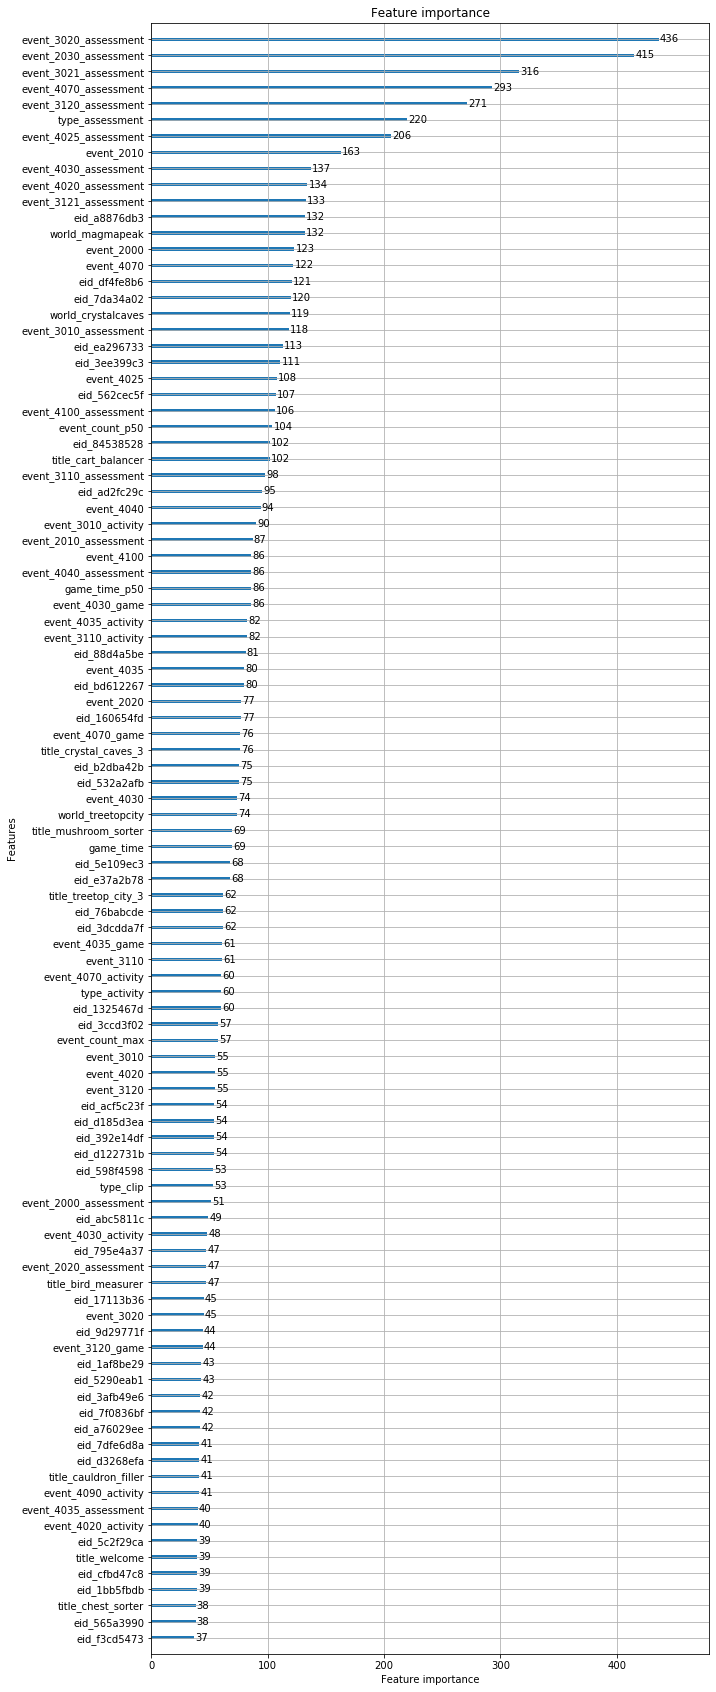

In [89]:
lgb.plot_importance(cv.best_estimator_['model'], max_num_features=100, figsize=(10, 30))

# Predict out of fold

In [82]:
oof = train[['installation_id']].copy()
oof[TARGET] = cv.predict(x_train)
assert oof[TARGET].min() > -0.5
assert oof[TARGET].max() < 3.5
oof[TARGET] = np.round(oof[TARGET]).astype(int)
oof.head()

,installation_id,accuracy_group
0,0006a69f,2
0,0006c192,1
0,00129856,3
0,001d0ed0,1
0,00225f67,0


In [83]:
score = cohen_kappa_score(oof[TARGET], y_train, weights='quadratic')
_log(f'oof score={score:.5f}')

oof score=0.80671


# Predict on Test set

In [84]:
x_test = test[PREDICTORS]
sub = test[['installation_id']].copy()
sub[TARGET] = cv.predict(x_test)
assert sub[TARGET].min() > -0.5
assert sub[TARGET].max() < 3.5
sub[TARGET] = np.round(sub[TARGET]).astype(int)
sub.head()

,installation_id,accuracy_group
0,00abaee7,3
0,01242218,2
0,017c5718,1
0,01a44906,1
0,01bc6cb6,1


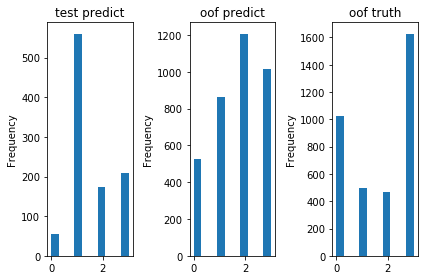

In [85]:
plt.subplot(1, 3, 1)
plt.title('test predict')
sub[TARGET].plot(kind='hist')
plt.subplot(1, 3, 2)
plt.title('oof predict')
oof[TARGET].plot(kind='hist')
plt.subplot(1, 3, 3)
plt.title('oof truth')
tmp = train[TARGET].copy()
tmp = tmp.astype(int)
tmp.plot(kind='hist')
plt.tight_layout()

In [86]:
sub.to_csv('submission.csv', index=False)
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'train.parquet']
